# Prediction of Billiards with velocities
In this experiment, we are trying to construct a model that is able to predict the future positions of one billiard ball, given the initial position and the initial velocity. We work with coordinate of ball, not with its image, that should simplify everything drastically. The main problem is ability of the model to detect collisions with laws and learn the corresponding reflectio law.

The code is written by Mehmet Kerem, modified by Ilya Schurov.

In [2]:
import sys
import os
sys.path.append(os.path.join('..', '..'))
# root directory of the project
from environments.billiards import Billiards

In [16]:
from keras.layers import (Input, Dense, Reshape, Flatten, Permute, 
                          TimeDistributed, Activation, Lambda, multiply, 
                          subtract, concatenate)
from keras.layers import (SimpleRNN, LSTM, GRU, Conv2D, MaxPooling2D, 
                          Bidirectional)
from keras.models import Model
from keras.losses import kullback_leibler_divergence
from keras.regularizers import L1L2, Regularizer
from keras.optimizers import RMSprop
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

env = Billiards(n=1)

M = 10000
# the number of samples

Y = np.zeros((M, env.T, env.n, 2))

# make input data from the environment
for i in range(M):
    env.make_steps()
    Y[i] = env.X
    

In [17]:
Y.shape

(10000, 128, 1, 2)

In [ ]:
# 10000 samples, 128 timesteps, 1 ball, 2 coordinates

In [18]:
X = np.copy(Y)
X[:,1:,:,:] = 0
# keep only the initial state

X = X[:,:-1,:,:]
# drop the last state

In [20]:
X.shape

(10000, 127, 1, 2)

In [21]:
Y.shape

(10000, 128, 1, 2)

In [22]:
Y = np.diff(Y, axis = 1)
# calculate the velocities

X = X.reshape((X.shape[0], X.shape[1], np.prod(X.shape[2:])))
Y = Y.reshape((Y.shape[0], Y.shape[1], np.prod(Y.shape[2:])))
# flatten last dimensions

In [23]:
X.shape

(10000, 127, 2)

In [25]:
Y.shape

(10000, 127, 2)

In [27]:
X = np.concatenate((X, Y), axis=-1)
# concatenate positions and veloctiies

In [29]:
X[:,1:,:] = 0
# keep only the initial timestep (position and velocity)

print('Shape of the X tensor: ' + str(X.shape))
print('Shape of the Y tensor: ' + str(Y.shape))

Shape of the X tensor: (10000, 127, 4)
Shape of the Y tensor: (10000, 127, 2)


In [32]:
## Create a predictor network
iD = Input(shape=X.shape[1:])
xD = iD
# xD = Dense(16, activation='relu')(xD) # Add a transformer layer in front
# xD = Bidirectional(GRU(128, return_sequences = True))(xD)
xD = GRU(128, return_sequences = True)(xD)
xD = Dense(Y.shape[2], activation='linear')(xD)
model = Model(inputs=iD, outputs=[xD], name='Predictor')
rmsprop = RMSprop(lr=1e-3)
model.compile(optimizer=rmsprop, loss=['mse'])
model.summary()
history = model.fit(X, Y, epochs=128, batch_size = 512, 
                    validation_split = 0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 127, 4)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 127, 128)          51072     
_________________________________________________________________
dense_1 (Dense)              (None, 127, 2)            258       
Total params: 51,330
Trainable params: 51,330
Non-trainable params: 0
_________________________________________________________________
Train on 7500 samples, validate on 2500 samples
Epoch 1/128
7500/7500 [==============================] - 22s 3ms/step - loss: 1.7627 - val_loss: 1.7022
Epoch 2/128
7500/7500 [==============================] - 31s 4ms/step - loss: 1.6258 - val_loss: 1.8296
Epoch 3/128
7500/7500 [==============================] - 27s 4ms/step - loss: 1.5456 - val_loss: 2.9726
Epoch 4/128
7500/7500 [===================

7500/7500 [==============================] - 20s 3ms/step - loss: 0.7672 - val_loss: 0.5159
Epoch 72/128
7500/7500 [==============================] - 23s 3ms/step - loss: 0.7491 - val_loss: 0.5564
Epoch 73/128
7500/7500 [==============================] - 25s 3ms/step - loss: 0.7538 - val_loss: 0.4937
Epoch 74/128
7500/7500 [==============================] - 27s 4ms/step - loss: 0.7410 - val_loss: 0.6159
Epoch 75/128
7500/7500 [==============================] - 24s 3ms/step - loss: 0.7299 - val_loss: 0.6673
Epoch 76/128
7500/7500 [==============================] - 31s 4ms/step - loss: 0.7346 - val_loss: 0.6748
Epoch 77/128
7500/7500 [==============================] - 26s 4ms/step - loss: 0.7218 - val_loss: 0.7049
Epoch 78/128
7500/7500 [==============================] - 22s 3ms/step - loss: 0.7264 - val_loss: 0.6712
Epoch 79/128
7500/7500 [==============================] - 22s 3ms/step - loss: 0.7186 - val_loss: 0.6958
Epoch 80/128
7500/7500 [==============================] - 22s 3ms/st

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def plot_balls(traj, mode='-', ax=None, label=None):
    tr = traj.reshape(-1, 1, 2)
    for i in range(1):
        if ax is None:
            plt.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)
        else:
            ax.plot(tr[:, i, 0], tr[:, i, 1], mode, label=label)

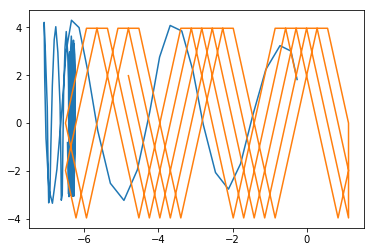

In [73]:
sample = 1
plot_balls(model.predict(X[sample:sample+1]).cumsum(axis=1))
plot_balls(Y[sample:sample+1].cumsum(axis=1))